# Experiment A: Linear Regression

In [0]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.optim.optimizer import Optimizer, required
import copy
from sklearn.linear_model import LinearRegression

In [0]:
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

# Define Optimisers

In [0]:
class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v

        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
             v = \rho * v + lr * g \\
             p = p - v

        The Nesterov version is analogously modified.
    """
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, heavy_ball=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        #add heavy ball flag into dict param list
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, 
                        heavy_ball=heavy_ball)
        
        #deal with heavy ball flag
        if heavy_ball and (momentum <= 0 or dampening != 0):
            raise ValueError("Heavy-ball momentum requires a momentum and zero dampening")

        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('heavy_ball', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            #read heavy ball flag
            heavy_ball = group['heavy_ball']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                        #init prev momentum space in GPU
                        param_state['prev_momentum_buffer'] = torch.zeros(buf.size()).cuda()
                    else:
                        buf = param_state['momentum_buffer']
                        #heavy ball iteration
                        prev_buf = param_state['prev_momentum_buffer']
                        if heavy_ball:
                            temp = buf
                            buf.add_(-prev_buf).mul_(momentum).add_(1 - dampening, d_p)
                            param_state['prev_momentum_buffer'] = temp
                        else:
                            buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

In [0]:
class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=0.001, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

# Define Distributions

In [0]:
import os
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='0'
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import nn

def get_batch(N,k,w):    
    X = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=torch.Tensor([0,0]), 
        covariance_matrix=torch.Tensor([[1., 0.],[0., 1/k]])).sample((N,))
    y = X@w+0.1 * torch.randn(N, 1)
    if torch.cuda.is_available(): 
        return Variable(X).cuda(),Variable(y).cuda()
    else:
        return Variable(X),Variable(y)
      
def discrete(N,k,w):
  X=torch.zeros(N,2)
  for i in range(0,N):
    weights = torch.tensor([0.5,0.5])
    dist=torch.multinomial(input=weights,num_samples=2).float()
    X[i]=dist
  X[:,1]=X[:,1].float()*(2.0/k)
  y= X@w  
  if torch.cuda.is_available(): 
        return Variable(X).cuda(),Variable(y).cuda()
  else:
        return Variable(X),Variable(y)

class LinearRegression_(nn.Module):
    def __init__(self):
        super(LinearRegression_,self).__init__()
        self.linear = nn.Linear(2,1)
    def forward(self,input):
        output = self.linear(input)
        return output    

# Gaussian

## Optimizer: **SGD**

In [0]:
lr=0.8
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_sgd=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = get_batch(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
#   print("init loss:",init_loss,"min:", values, "index:",indices)  
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))
  converge_rate_sgd.append(indices.float()/(torch.log(init_loss) - torch.log(values)))
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 16
tensor([13.3755], device='cuda:0')
Verify convergence, k= 32
tensor([25.2634], device='cuda:0')
Verify convergence, k= 64
tensor([52.5534], device='cuda:0')
Verify convergence, k= 128
tensor([112.1091], device='cuda:0')
Verify convergence, k= 256
tensor([207.5207], device='cuda:0')
Verify convergence, k= 512
tensor([532.9840], device='cuda:0')
Verify convergence, k= 1024
tensor([867.4553], device='cuda:0')
Verify convergence, k= 2048
tensor([1775.9817], device='cuda:0')
Verify convergence, k= 4096
tensor([3636.4351], device='cuda:0')


## Optimiser: AccSGD

In [0]:
lr=0.8
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_accsgd=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = get_batch(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = AccSGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))  
  converge_rate_accsgd.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([13.3761], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([15.7301], device='cuda:0')
Verify convergence, k= 64
tensor([40.8566], device='cuda:0')
Verify convergence, k= 128
tensor([109.9938], device='cuda:0')
Verify convergence, k= 256
tensor([192.3683], device='cuda:0')
Verify convergence, k= 512
tensor([233.9825], device='cuda:0')
Verify convergence, k= 1024
tensor([276.7783], device='cuda:0')
Verify convergence, k= 2048
tensor([226.8891], device='cuda:0')
Verify convergence, k= 4096
tensor([710.3593], device='cuda:0')


## Optimiser: Heavyball

In [0]:
lr=0.8
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_hb=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = get_batch(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = SGD(model.parameters(), lr=lr, momentum=0.2, heavy_ball=True)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))   
  converge_rate_hb.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([13.3755], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([25.2634], device='cuda:0')
Verify convergence, k= 64
tensor([52.5534], device='cuda:0')
Verify convergence, k= 128
tensor([112.6379], device='cuda:0')
Verify convergence, k= 256
tensor([210.1559], device='cuda:0')
Verify convergence, k= 512
tensor([544.1057], device='cuda:0')
Verify convergence, k= 1024
tensor([873.4425], device='cuda:0')
Verify convergence, k= 2048
tensor([1775.9817], device='cuda:0')
Verify convergence, k= 4096
tensor([3705.9595], device='cuda:0')


## Optimiser: NAG

In [0]:
lr=0.8
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_nag=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = get_batch(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = SGD(model.parameters(), lr=lr, momentum=0.2, nesterov=True)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))   
  converge_rate_nag.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([13.3877], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([23.5156], device='cuda:0')
Verify convergence, k= 64
tensor([52.5539], device='cuda:0')
Verify convergence, k= 128
tensor([104.3531], device='cuda:0')
Verify convergence, k= 256
tensor([199.9445], device='cuda:0')
Verify convergence, k= 512
tensor([485.9308], device='cuda:0')
Verify convergence, k= 1024
tensor([740.5273], device='cuda:0')
Verify convergence, k= 2048
tensor([1487.7032], device='cuda:0')
Verify convergence, k= 4096
tensor([2901.8933], device='cuda:0')


## Optimiser: Adam

In [0]:
lr=0.8
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_adam=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = get_batch(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))   
  converge_rate_adam.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([13.2242], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([24.7867], device='cuda:0')
Verify convergence, k= 64
tensor([37.2322], device='cuda:0')
Verify convergence, k= 128
tensor([47.2409], device='cuda:0')
Verify convergence, k= 256
tensor([55.3388], device='cuda:0')
Verify convergence, k= 512
tensor([44.9144], device='cuda:0')
Verify convergence, k= 1024
tensor([456.3934], device='cuda:0')
Verify convergence, k= 2048
tensor([439.4182], device='cuda:0')
Verify convergence, k= 4096
tensor([1784.5889], device='cuda:0')


## Optimiser: Adagrad

In [0]:
lr=0.8
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_adagrad=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = get_batch(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))   
  converge_rate_adagrad.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([9.4814], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([10.1689], device='cuda:0')
Verify convergence, k= 64
tensor([5.6013], device='cuda:0')
Verify convergence, k= 128
tensor([5.9933], device='cuda:0')
Verify convergence, k= 256
tensor([9.2231], device='cuda:0')
Verify convergence, k= 512
tensor([10.2661], device='cuda:0')
Verify convergence, k= 1024
tensor([8.8952], device='cuda:0')
Verify convergence, k= 2048
tensor([11.4881], device='cuda:0')
Verify convergence, k= 4096
tensor([12.0912], device='cuda:0')


## Plot the figures

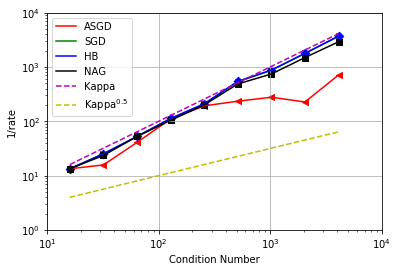

In [0]:
for i in range(0,9):
  plt.scatter(k[i],converge_rate_accsgd[i].cpu().detach().numpy(), c="r",marker="<")
  plt.scatter(k[i],converge_rate_sgd[i].cpu().detach().numpy(), c="g",marker=">")
  plt.scatter(k[i],converge_rate_hb[i].cpu().detach().numpy(), c="b",marker="D")
  plt.scatter(k[i],converge_rate_nag[i].cpu().detach().numpy(), c="k",marker="s")
#   plt.scatter(k[i],converge_rate_adam[i].cpu().detach().numpy(), c="m",marker=".")  
#   plt.scatter(k[i],converge_rate_adagrad[i].cpu().detach().numpy(), c="y",marker="o")
def create_list(converge_rate_nag):
  c = []
  for con in converge_rate_nag:
    c.append(con.cpu().detach().numpy())
  return c

kkk = []
kkk_sqt=[]
for kk in k:
    kkk.append(kk)
    kkk_sqt.append(kk**(0.5))
    
cacc = create_list(converge_rate_accsgd)
csgd = create_list(converge_rate_sgd)
chb = create_list(converge_rate_hb)
cnag = create_list(converge_rate_nag)
# cadam = create_list(converge_rate_adam)
# cadagrad = create_list(converge_rate_adagrad)


# plt.scatter(k[i],converge_rate[i].cpu().detach().numpy())
plt.plot(kkk,cacc,label='ASGD',c="r")
plt.plot(kkk,csgd,label='SGD',c="g")
plt.plot(kkk,chb,label='HB',c="b")
plt.plot(kkk,cnag,label='NAG',c="k")
# plt.plot(kkk,cadam,label='ADAM',c="m")
# plt.plot(kkk,cadagrad,label='ADAGRAD',c="y")

plt.plot(kkk,kkk,label='Kappa',color='m',linestyle='--')
plt.plot(kkk,kkk_sqt,label='Kappa$^{0.5}$',color='y',linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Condition Number")
plt.ylabel("1/rate")
plt.xlim(10,10**4)
plt.ylim(1,10**4)
plt.grid(axis='both')
plt.savefig("expaGaussian.pdf")
plt.show()

In [0]:
from google.colab import files
files.download("./expaGaussian.pdf")

## Calculate Slope
  X_inv = torch.pinverse(X)
  
  theta_pinv = torch.mm(X_inv, y)

In [0]:
x = np.zeros((9,1))
for i in range(0,9):
  x[i] = kkk.pop()
  
X = torch.rand(9,2)
X[:,1]=1.0
for i in range(0,9):
  X[i,0]=x[i][0]
  
  
#AccSGD
y1 = np.zeros((9,1))
for i in range(0,9):
  y1[i] = cacc.pop()
Y1 = torch.rand(9,1)
for i in range(0,9):
  Y1[i]=y1[i][0]
#SGD
y2 = np.zeros((9,1))
for i in range(0,9):
  y2[i] = csgd.pop()
Y2 = torch.rand(9,1)
for i in range(0,9):
  Y2[i]=y2[i][0]
#HB 
y3 = np.zeros((9,1))
for i in range(0,9):
  y3[i] = chb.pop()
Y3 = torch.rand(9,1)
for i in range(0,9):
  Y3[i]=y3[i][0]
#NAG  
y4 = np.zeros((9,1))
for i in range(0,9):
  y4[i] = cnag.pop()
Y4 = torch.rand(9,1)
for i in range(0,9):
  Y4[i]=y4[i][0]
  
  
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y1)
print('Acc Weight=',theta_pinv)
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y2)
print('SGD Weight=',theta_pinv)
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y3)
print('HB Weight=',theta_pinv)
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y4)
print('NAG Weight=',theta_pinv)

Acc Weight= tensor([[ 0.1466],
        [69.0817]])
SGD Weight= tensor([[ 0.8836],
        [-0.0662]])
HB Weight= tensor([[ 0.8980],
        [-3.2066]])
NAG Weight= tensor([[ 0.7060],
        [26.3799]])


# Discrete

## Optimizer: SGD

In [0]:
lr=0.02
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD

k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_sgd=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = discrete(N,k[i],w)
  
#   X = X.cuda()
#   y = y.cuda()
  
  model = LinearRegression_().cuda()
  optimizer = SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
    
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
#   print(loss_list[i])
#   print("init loss:",init_loss,"min:", values, "index:",indices)  
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))
  converge_rate_sgd.append(indices.float()/(torch.log(init_loss) - torch.log(values)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 16
tensor([19.1174], device='cuda:0')
Verify convergence, k= 32
tensor([37.6568], device='cuda:0')
Verify convergence, k= 64
tensor([47.1730], device='cuda:0')
Verify convergence, k= 128
tensor([60.7586], device='cuda:0')
Verify convergence, k= 256
tensor([64.1577], device='cuda:0')
Verify convergence, k= 512
tensor([65.1420], device='cuda:0')
Verify convergence, k= 1024
tensor([68.6139], device='cuda:0')
Verify convergence, k= 2048
tensor([71.0744], device='cuda:0')
Verify convergence, k= 4096
tensor([65.0008], device='cuda:0')


## Optimizer: AccSGD

In [0]:
lr=0.02
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_accsgd=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = discrete(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = AccSGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))  
  converge_rate_accsgd.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([14.5285], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([10.2426], device='cuda:0')
Verify convergence, k= 64
tensor([16.0110], device='cuda:0')
Verify convergence, k= 128
tensor([27.1964], device='cuda:0')
Verify convergence, k= 256
tensor([32.5287], device='cuda:0')
Verify convergence, k= 512
tensor([42.8447], device='cuda:0')
Verify convergence, k= 1024
tensor([46.9705], device='cuda:0')
Verify convergence, k= 2048
tensor([32.6414], device='cuda:0')
Verify convergence, k= 4096
tensor([34.1260], device='cuda:0')


##Optimiser: Heavyball

In [0]:
lr=0.02
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_hb=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = discrete(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = SGD(model.parameters(), lr=lr, momentum=0.8, heavy_ball=True)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))   
  converge_rate_hb.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([19.0547], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([37.5448], device='cuda:0')
Verify convergence, k= 64
tensor([47.0896], device='cuda:0')
Verify convergence, k= 128
tensor([60.6852], device='cuda:0')
Verify convergence, k= 256
tensor([64.1103], device='cuda:0')
Verify convergence, k= 512
tensor([65.0666], device='cuda:0')
Verify convergence, k= 1024
tensor([68.6139], device='cuda:0')
Verify convergence, k= 2048
tensor([71.0741], device='cuda:0')
Verify convergence, k= 4096
tensor([64.9631], device='cuda:0')


## Optimiser: NAG

In [0]:
lr=0.02
N=1000
w0 = dis_w=torch.tensor([[1.5],[2]])

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# optimizer: SGD


k=torch.zeros(9)

final_loss=torch.zeros(9)
min_loss=torch.zeros(9)
min_loss_index=torch.zeros(9)
converge_rate_nag=[]
  
for i in range (0,9):
  weight=[]
  init_loss = 0
  k[i]= 2**(i+4)
  iteration=torch.tensor(5*k[i]).int()
  loss_list=torch.zeros(9,iteration).cuda()
  w = w0
  X, y = discrete(N,k[i],w)
  
  model = LinearRegression_().cuda()
  optimizer = SGD(model.parameters(), lr=lr, momentum=0.8, nesterov=True)
  criterion = nn.MSELoss()
  
  
  for t in range(0, iteration):
    weight.append(model.parameters())
    output = model(X)
    loss = criterion(output,y)
    loss_value = loss.data
    loss_list[i][t]=loss_value
    if t == 0:
      init_loss = loss_value
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  values, indices = torch.min(loss_list[i],dim=0,keepdim=True)
  min_loss[i]=values
  min_loss_index[i]=indices
  wt=weight[indices]
  
  # verify convergence
  print("Verify convergence, k=",int(k[i]))
  for j in range (iteration/2, iteration):
    if loss_list[i][j] < init_loss:
      pass
    else:
      print("not converge")
      break
  print((indices.float()/(torch.log(init_loss) - torch.log(values))))   
  converge_rate_nag.append(indices.float()/(torch.log(init_loss) - torch.log(min_loss[i])))

Verify convergence, k= 16
tensor([7.9330], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Verify convergence, k= 32
tensor([9.7684], device='cuda:0')
Verify convergence, k= 64
tensor([10.7989], device='cuda:0')
Verify convergence, k= 128
tensor([10.9026], device='cuda:0')
Verify convergence, k= 256
tensor([13.3287], device='cuda:0')
Verify convergence, k= 512
tensor([10.2735], device='cuda:0')
Verify convergence, k= 1024
tensor([16.9008], device='cuda:0')
Verify convergence, k= 2048
tensor([15.5972], device='cuda:0')
Verify convergence, k= 4096
tensor([10.5875], device='cuda:0')


## Plot the figures

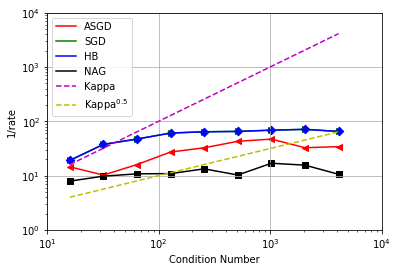

In [0]:
for i in range(0,9):
  plt.scatter(k[i],converge_rate_accsgd[i].cpu().detach().numpy(), c="r",marker="<")
  plt.scatter(k[i],converge_rate_sgd[i].cpu().detach().numpy(), c="g",marker=">")
  plt.scatter(k[i],converge_rate_hb[i].cpu().detach().numpy(), c="b",marker="D")
  plt.scatter(k[i],converge_rate_nag[i].cpu().detach().numpy(), c="k",marker="s")

def create_list(converge_rate_nag):
  c = []
  for con in converge_rate_nag:
    c.append(con.cpu().detach().numpy())
  return c

kkk = []
kkk_sqt=[]
for kk in k:
    kkk.append(kk)
    kkk_sqt.append(kk**(0.5))
    
cacc = create_list(converge_rate_accsgd)
csgd = create_list(converge_rate_sgd)
chb = create_list(converge_rate_hb)
cnag = create_list(converge_rate_nag)
# plt.scatter(k[i],converge_rate[i].cpu().detach().numpy())
plt.plot(kkk,cacc,label='ASGD',c="r")
plt.plot(kkk,csgd,label='SGD',c="g")
plt.plot(kkk,chb,label='HB',c="b")
plt.plot(kkk,cnag,label='NAG',c="k")
plt.plot(kkk,kkk,label='Kappa',color='m',linestyle='--')
plt.plot(kkk,kkk_sqt,label='Kappa$^{0.5}$',color='y',linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Condition Number")
plt.ylabel("1/rate")
plt.xlim(10,10**4)
plt.ylim(1,10**4)
plt.grid(axis='both')
plt.savefig("expaDiscrete1.pdf")
plt.show()

In [0]:
files.download("./expaDiscrete1.pdf")

## Calculate Slope

In [0]:
x = np.zeros((9,1))
for i in range(0,9):
  x[i] = kkk.pop()
  
X = torch.rand(9,2)
X[:,1]=1.0
for i in range(0,9):
  X[i,0]=x[i][0]
  
  
#AccSGD
y1 = np.zeros((9,1))
for i in range(0,9):
  y1[i] = cacc.pop()
Y1 = torch.rand(9,1)
for i in range(0,9):
  Y1[i]=y1[i][0]
#SGD
y2 = np.zeros((9,1))
for i in range(0,9):
  y2[i] = csgd.pop()
Y2 = torch.rand(9,1)
for i in range(0,9):
  Y2[i]=y2[i][0]
#HB 
y3 = np.zeros((9,1))
for i in range(0,9):
  y3[i] = chb.pop()
Y3 = torch.rand(9,1)
for i in range(0,9):
  Y3[i]=y3[i][0]
#NAG  
y4 = np.zeros((9,1))
for i in range(0,9):
  y4[i] = cnag.pop()
Y4 = torch.rand(9,1)
for i in range(0,9):
  Y4[i]=y4[i][0]
  
  
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y1)
print('Acc Weight=',theta_pinv)
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y2)
print('SGD Weight=',theta_pinv)
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y3)
print('HB Weight=',theta_pinv)
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, Y4)
print('NAG Weight=',theta_pinv)

Acc Weight= tensor([[3.7816e-03],
        [2.5130e+01]])
SGD Weight= tensor([[6.0977e-03],
        [4.9871e+01]])
HB Weight= tensor([[6.1126e-03],
        [4.9803e+01]])
NAG Weight= tensor([[4.9772e-04],
        [1.1336e+01]])
